# Overview
The data was initially provided in a sqlite database.

# Initial Data Preparation

In [20]:
# a small piece of code to find the data folder
import os, importlib
from pathlib import Path

NOTEBOOK_SCRIPT = os.getcwd()

current = NOTEBOOK_SCRIPT
while 'data' not in os.listdir(current):
    current = Path(current).parent

DATA_FOLDER = os.path.join(current, 'data')

In [21]:
# let's extract all the features needed in the data. 
import data_preparation as dpre
importlib.reload(dpre)


db_file = os.path.join(DATA_FOLDER, 'F24.ML.Assignment.One.data.db')
df_save_file = os.path.join(DATA_FOLDER, 'data.csv')
df = dpre.data_to_df(db_file, 
           df_save_file, 
           overwrite=False # no need to execute the same lengthy query if the .csv file already exists...
           )

In [22]:
df.head()

,order_id,start_prep_date,finish_prep_date,profit,delivery_distance,STATUS_ID,planned_prep_time,product_id,store_id,price
0,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99278,3750,26.07
1,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99283,3750,7.11
2,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99285,3750,7.11
3,18671225,2024-05-08 00:02:01,2024-05-08 00:10:29,15.8,560,F,15.0,298529,5863,31.60
4,18671227,2024-05-08 00:01:50,2024-05-08 00:49:19,6.0040000000000004,4396,F,20.0,399309,8721,30.02


## Observations


* the preparation time (in mintues) which is defined as the difference between finish_prep_data and start_prep_date seems to be only dependent on the order_id. In other words, all items within the same order will have the same preparation time. THIS IS IMPORTANT TO AVOID DATA LEAKAGE AS A SOPHITICATED MODEL (SUCH AS NEURAL NETWORK) CAN EASILY MEMORIZE THE ORDER ID, MAP IT TO ITS LABEL.

* some potential features : the number of items in the order, the average / median price of the order, the average prep time of the store, 

* potential features from the timestamps: the day of the week, the time of the day (maybe service is simply slower later during the day..)


# Data Preparation

## Remove Missing labels
Before moving to data splitting, it is necessary to make sure the 'fields' needed to compute the label are not missing.

In [23]:
import pandas as pd
import numpy as np
missing_data = np.mean(df.isna(), axis=0)
missing_data

order_id             0.000000
start_prep_date      0.000000
finish_prep_date     0.000000
profit               0.099278
delivery_distance    0.000000
STATUS_ID            0.000000
planned_prep_time    0.000004
product_id           0.000000
store_id             0.000000
price                0.100164
dtype: float64

1\% of the data has either `finish_prep_date` or `start_prep_date` missing. To avoid introducing bias, remove those samples. Since `planned_prep_time` is intuitively a very good indicator of the actual preparation time, we will also remove the very few samples with missing `planned_prep_time`. 

One possible caveat is that missing data might be spread across multiple samples which might lead to removing a very large of samples. However since the maximum number of samples with missing data for either `finish_prep_date` or `start_prep_date` is (1\% + 1\% = 2\%). The removal procedure will cost us at most 2\% of the samples. We can most probably live with such a tiny loss.

(We'll verify below just to be sure)

In [24]:
importlib.reload(dpre)
samples_with_missing = dpre.samples_with_missing_data(df, columns=['planned_prep_time'], missing_data_rel='or', objective='locate')
print(f"missing ratio: {len(samples_with_missing) / len(df)}") 


missing ratio: 3.6493553413789454e-06


In [ ]:

# we are loosing only 1% of the data...
df = dpre.samples_with_missing_data(df, columns=['planned_prep_time'], missing_data_rel='or', objective='remove')

# prepare the date
df = dpre.prepare_labels(df)
df.head()

In [6]:
df.sort_values(by='y', ascending=False)

,order_id,finish_prep_date,start_prep_date,planned_prep_time,store_id,product_id,price,product_creation_date,y
1422168,19802795,2024-07-19 13:10:54,2024-07-18 20:37:55,10.0,8715,699329,11.850,2023-08-22 06:47:06.607231,992.0
1422167,19802795,2024-07-19 13:10:54,2024-07-18 20:37:55,10.0,8715,695653,NaN,2022-11-16 07:03:29.326277,992.0
1422166,19802795,2024-07-19 13:10:54,2024-07-18 20:37:55,10.0,8715,695611,28.440,2022-11-13 14:55:00.515801,992.0
1051302,19993783,2024-07-31 01:33:11,2024-07-30 14:35:00,10.0,6299,1289185,104.280,2023-09-25 20:49:22.625815,658.0
1051301,19993783,2024-07-31 01:33:11,2024-07-30 14:35:00,10.0,6299,144177,34.523,2023-12-31 14:43:27.358697,658.0
...,...,...,...,...,...,...,...,...,...
1729329,19640657,2024-07-08 18:20:57,2024-07-08 18:20:57,40.0,10657,1058909,11.850,2023-07-07 14:19:46.797342,0.0
1729328,19640657,2024-07-08 18:20:57,2024-07-08 18:20:57,40.0,10657,1058909,11.850,2023-07-06 06:53:42.200075,0.0
1729327,19640657,2024-07-08 18:20:57,2024-07-08 18:20:57,40.0,10657,1058899,11.850,2024-01-12 08:43:36.527159,0.0
1729326,19640657,2024-07-08 18:20:57,2024-07-08 18:20:57,40.0,10657,1058899,11.850,2023-08-07 12:26:35.405315,0.0


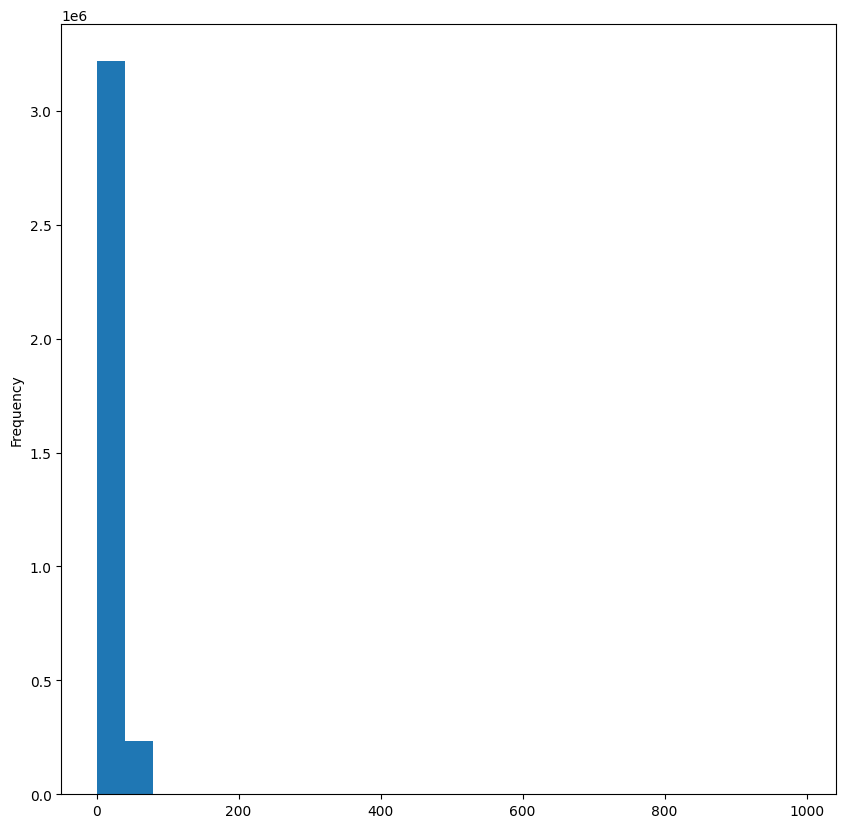

In [8]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 10))
# df['y'].plot.hist(bins=25)
# plt.show()


## Split Data

In [7]:
# according to the assignment requirements, the data must be split into train and test with test representing 10% of the data
importlib.reload(dpre)
df_train, df_test = dpre.df_split(df, splits=(0.9, 0.1))

In [8]:
# everything seems to checkout !!!
len(df_train), len(df_test), round(len(df_train) / len(df_test), 4) 

(3111552, 346309, 8.9849)

## Impute Missing data:  The price column

We can assume that the same product_id is associated with the same price tag.

In [21]:
PRODUCT_PRICE_TRAIN = pd.pivot_table(df_train, values=['price'], index='product_id', aggfunc=['min', 'median', 'mean', 'count', lambda x: x.isna().sum()])
PRODUCT_PRICE_TRAIN

,min,median,mean,count,<lambda>
,price,price,price,price,price
product_id,,,,,
29049,47.40,47.40,47.40,2637,300
29060,94.80,94.80,94.80,165,21
29115,31.60,31.60,31.60,78,9
29127,79.00,79.00,79.00,18,2
29139,35.55,35.55,35.55,76,8
...,...,...,...,...,...
1315027,NaN,NaN,NaN,0,1
1315631,NaN,NaN,NaN,0,1


product_ids have Nan prices in certain samples and non-na value in others. We can use the aggregated values to impute the nan values. However, we still have samples without a price value at all.

In [22]:
PRODUCT_PRICE_TRAIN.isna().sum()
# keep pnly the mean price
PRODUCT_PRICE_TRAIN.columns = PRODUCT_PRICE_TRAIN.columns.droplevel(1)
PRODUCT_PRICE_TRAIN = PRODUCT_PRICE_TRAIN.rename(columns={"mean": "mean_price"}).reset_index()
PRODUCT_PRICE_TRAIN = PRODUCT_PRICE_TRAIN[['product_id', 'mean_price']]
PRODUCT_PRICE_TRAIN.head()

,product_id,mean_price
0,29049,47.40
1,29060,94.80
2,29115,31.60
3,29127,79.00
4,29139,35.55


In [23]:
def impute_price(df: pd.DataFrame):
	return pd.merge(df, PRODUCT_PRICE_TRAIN, 
				how='left', 
				left_on='product_id', 
				right_on='product_id')

df_train = impute_price(df_train)

In [24]:
df_train.isna().sum()
# as we can see here the number of Nan 'prices' was reduced from  300k to a mere 1.5k
# I am unlikely to use the exact price of an item.
df_train = df_train.drop(columns=['price']).rename(columns={"mean_price": "price"})

df_test = impute_price(df_test)
df_test = df_test.drop(columns=['price']).rename(columns={"mean_price": "price"})

# EDA

## Feature clasification: Encoding categorical features
Before applying feature enginnering techniques, it is important to understand the type of data we have: categorial, numerical...

In [27]:
df_train.nunique()

order_id                 461139
start_prep_date          445570
planned_prep_time           103
store_id                   1415
product_id                55382
product_creation_date     74941
y                           164
price                      8757
dtype: int64

The features can be classified as follows:

1. Categorical: 
	* product_id
	* store_id
	* order_id: if the product_id does not make a difference, then we will use group by the order id and reduce the number of samples...

2. Continuous:
	* planned prep time
	* price

3. time:
	* start_prep_time: extract the day of the week, the hour, the number of orders a store has received in the last "x" minutes
	* product creation time

Few observations: 

* too many products
* either discard products in general (if most of them were ordered only once or twice) or somehow laverage the frequntly ordered products
* we have few stores which means we can build some 
* the price needs to aggregated across all items in the order


### Product Id

In [44]:
product_counts = pd.pivot_table(df_train, index='product_id', values='price', aggfunc='count')['price'].sort_values(ascending=False)
product_counts

product_id
688359     57154
31367      17270
31373      17039
771477     15368
1063607    14928
           ...  
413417         0
1286851        0
1286849        0
109280         0
302381         0
Name: price, Length: 55382, dtype: int64

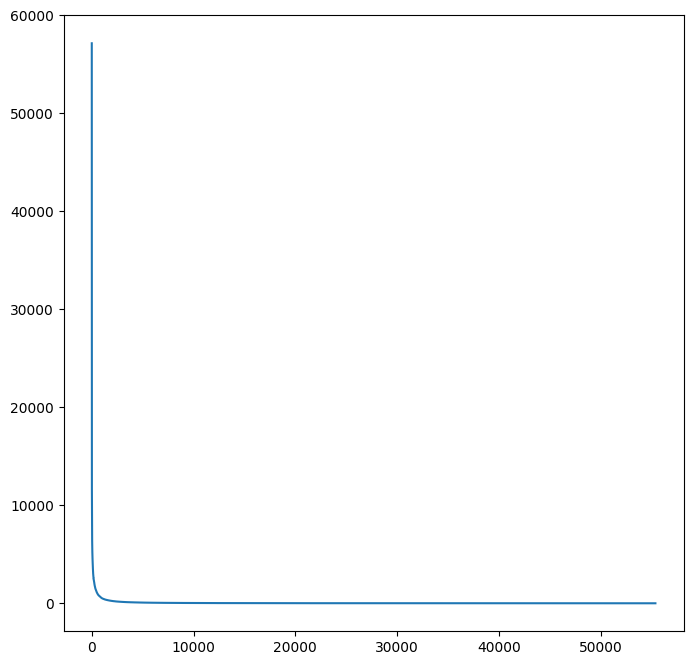

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 8))
plt.plot(list(range(len(product_counts))), product_counts.values)
plt.show()

In [50]:
FREQUENT_PRODUCTS_IDS = product_counts[product_counts >= 50].index.tolist()
freq_prod_orders = df_train[df_train['product_id'].isin(FREQUENT_PRODUCTS_IDS)]
freq_prod_y_stats = pd.pivot_table(freq_prod_orders, values=['y'], index=['product_id', 'store_id'], aggfunc=['mean', 'std', 'median', 'min', 'max'])

In [51]:
freq_prod_y_stats.head(20)

mean        std median   min   max
                             y          y      y     y     y
product_id store_id                                         
29049      3053      24.834270  14.157425   27.0   0.0  63.0
           3496      23.347578  13.077525   25.0   0.0  57.0
           5719      20.985294  12.223071   23.0   0.0  54.0
29060      3053      26.869565  15.546811   30.0   0.0  64.0
           3496      24.966667  14.587550   26.5   0.0  50.0
           5719      28.111111  10.832051   31.0   0.0  37.0
29115      3053      21.000000  10.786465   26.5   0.0  31.0
           3496      17.384615  15.936742   21.0   0.0  45.0
           5719      17.750000  11.844096   22.0   0.0  32.0
29139      3063      24.047619  14.071166   26.0   0.0  64.0
29140      3063      25.785047  14.652598   28.0   0.0  70.0
29141      3063      21.469697  13.473666   23.0   0.0  55.0
29149      3063      25.450980  15.013745   28.0   0.0  70.0
29848      3053      27.679245  14.379275   31.0   0.0  62.0
           3496      22.164384  15.367976   25.0   0.0  67.0
           5719      21.800000  13.387793   23.0   0.0  46.0
29886      3058      24.681818  12.150542   26.5   0.0  46.0
           3059      19.333333   3.605551   18.0  16.0  24.0
           3270      24.000000  10.303099   24.0   0.0  37.0
30299      3053      23.803922  11.691798   26.0   0.0  44.0